## Notebook contents: logistic regression, RFLR, HMM, FQ-learning models fit to 2ABT data
This notebook provides an overview of fitting and predicting mouse behavior in a two-armed bandit using descriptive, algorithmic, and theoretical models.


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import plot_models_v_mouse as bp
import model_policies as models
from sklearn.model_selection import train_test_split
import conditional_probs as cprobs
import resample_and_model_reps as reps
import model_fitting as fit

# Load in data and train-test-split

In [2]:
data = pd.read_csv(os.path.join('mouse_data.csv'))
data.head()

,Trial,blockTrial,Decision,Switch,Reward,Condition,Target,blockLength,Session,Mouse
0,11.0,11.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
1,12.0,12.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
2,13.0,13.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
3,14.0,14.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
4,15.0,15.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1


In [3]:
probs='80-20' # P(high)-P(low)
seq_nback=3 # history length for conditional probabilites
train_prop=0.7 # for splitting sessions into train and test
seed = np.random.randint(1000) # set seed for reproducibility

data = data.loc[data.Condition==probs] # segment out task condition

In [16]:
data

,Trial,blockTrial,Decision,Switch,Reward,Condition,Target,blockLength,Session,Mouse,decision_seq,reward_seq,history,RL_history,block_pos_rev,model,highPort
0,11.0,11.0,0.0,1.0,1.0,80-20,0.0,12.0,m1_63,m1,NaN,NaN,NaN,NaN,-1.0,mouse,True
1,12.0,12.0,0.0,0.0,1.0,80-20,0.0,12.0,m1_63,m1,NaN,NaN,NaN,NaN,0.0,mouse,True
2,13.0,0.0,0.0,0.0,0.0,80-20,1.0,53.0,m1_63,m1,NaN,NaN,NaN,NaN,-53.0,mouse,False
3,14.0,1.0,0.0,0.0,0.0,80-20,1.0,53.0,m1_63,m1,000,110,AAa,RRr,-52.0,mouse,False
4,15.0,2.0,1.0,1.0,1.0,80-20,1.0,53.0,m1_63,m1,000,100,Aaa,Rrr,-51.0,mouse,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117329,859.0,63.0,1.0,0.0,0.0,80-20,0.0,68.0,m6_34,m6,111,000,aaa,lll,-5.0,mouse,False
117330,860.0,64.0,1.0,0.0,0.0,80-20,0.0,68.0,m6_34,m6,111,000,aaa,lll,-4.0,mouse,False
117331,861.0,65.0,1.0,0.0,1.0,80-20,0.0,68.0,m6_34,m6,111,000,aaa,lll,-3.0,mouse,False
117332,862.0,66.0,1.0,0.0,0.0,80-20,0.0,68.0,m6_34,m6,111,001,aaA,llL,-2.0,mouse,False


In [4]:
data = cprobs.add_history_cols(data, seq_nback) # set history labels up front

train_session_ids, test_session_ids = train_test_split(data.Session.unique(), 
                                                       train_size=train_prop, random_state=seed) # split full df for train/test

data['block_pos_rev'] = data['blockTrial'] - data['blockLength'] # reverse block position from transition
data['model']='mouse'
data['highPort'] = data['Decision']==data['Target'] # boolean, chose higher probability port

train_features, _, _ = reps.pull_sample_dataset(train_session_ids, data)
test_features, _, block_pos_core = reps.pull_sample_dataset(test_session_ids, data)

bpos_mouse = bp.get_block_position_summaries(block_pos_core)
bpos_mouse['condition'] = 'mouse'

# Plot conditional switch probabilities for just the mouse behavior first
Sort held out conditioned history sequences by full dataset P(switch|sequence)

In [5]:
# full dataset for sorting
df_mouse_symm_reference = cprobs.calc_conditional_probs(data, symm=True, 
                                                        action=['Switch']).sort_values('pswitch')

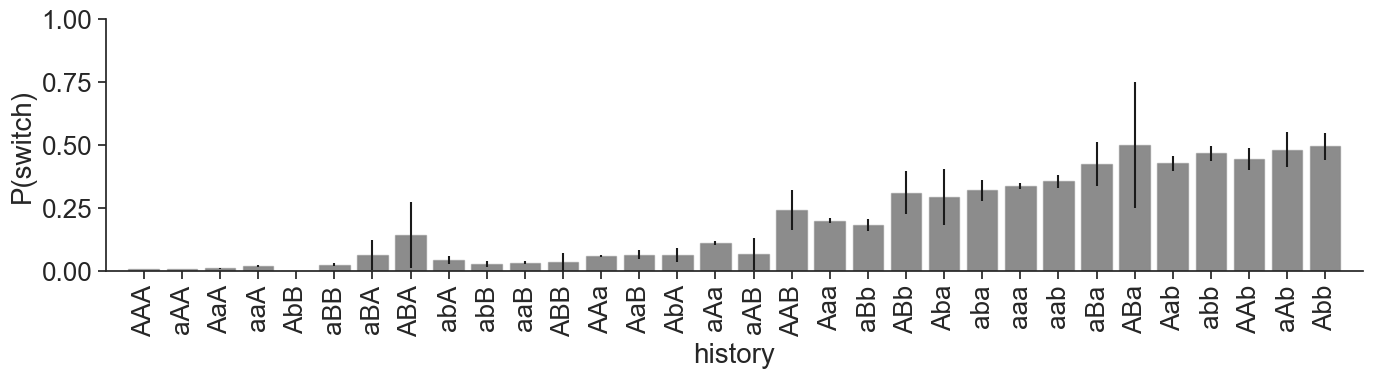

In [6]:
df_mouse_symm = cprobs.calc_conditional_probs(block_pos_core, symm=True, action=['Switch', 'Decision'])
df_mouse_symm = cprobs.sort_cprobs(df_mouse_symm, df_mouse_symm_reference.history.values)
bp.plot_sequences(df_mouse_symm, alpha=0.5) 

# Fit models on training data, predict choice probabilities for held-out data
Model predictions (`model_probs`) for each held out session stored for plotting below.

## Logistic regression
Fit logistic regression on training set, with coefficients for choice history (up to trial n-L1), choice-reward interaction (up to trial n-L2), and reward history (up to trial n-L3).

In [7]:
L1 = 1 # choice history
L2 =  5 # choice * reward history
L3 = 0
memories = [L1, L3, L2, 1]

lr = models.fit_logreg_policy(train_features, memories) # refit model with reduced histories, training set
model_probs = models.compute_logreg_probs(test_features, lr_args=[lr, memories])

## Recursively formulated logistic regression (RFLR)

In [14]:
%%time

# should take about 10 min
params, nll = fit.fit_with_sgd(fit.log_probability_rflr, train_features) # quick fit on RFLR parameters
alpha, beta, tau = params
print(f'alpha = {alpha[0]:.2f}')
print(f'beta = {beta[0]:.2f}')
print(f'tau = {tau[0]:.2f}')

model_probs = models.RFLR(test_features, params)

iteration  0 neg ll:  0.22532275
iteration  125000 neg ll:  0.18618675
iteration  250000 neg ll:  0.18618675
iteration  375000 neg ll:  0.18618675
alpha = 0.78
beta = 2.10
tau = 1.35
CPU times: total: 24min 31s
Wall time: 24min 30s


In [15]:
nll

DeviceArray(0.18618675, dtype=float32, weak_type=True)

## Hidden Markov model (HMM)

In [11]:
q = 0.98 # 1-p(block transition)
p = 0.8 # p(reward | high port)

model_probs = models.compute_hmm_probs(test_features, parameters={'q':q, 'p':p})

## forgetting Q-learning model (F-Q model)
Using $\alpha$, $\beta$, and $\tau$ parameters derived from fit RFLR above.

In [17]:
alpha = 0.77
beta = 2.24
tau = 1.33

In [18]:
T = (1-np.exp(-1/tau))/beta 
k = 1-np.exp(-1/tau) 
a = alpha 

model_probs = models.fq_learning_model(test_features, parameters=[a, k, T])

# Predict action and plot
Apply policy ('greedy', 'stochastic', or 'softmax') to select actions from `model_probs` and plot behavior. Can add replicate runs for stochastic policies.

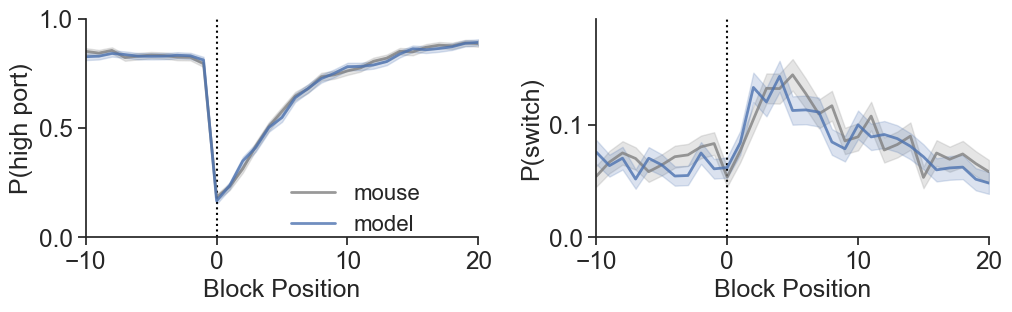

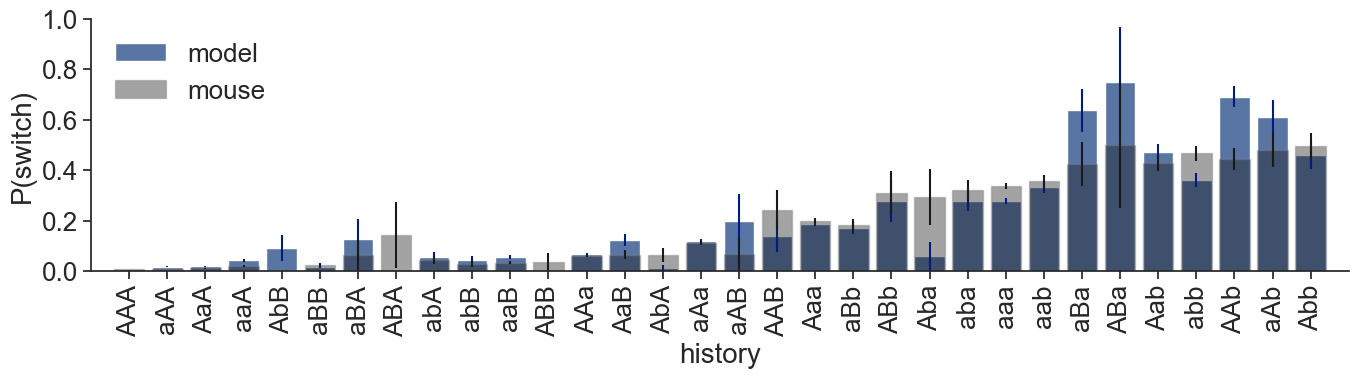

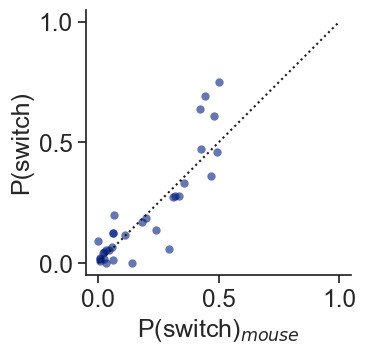

In [11]:
model_choices, model_switches = models.model_to_policy(model_probs, test_features, policy='stochastic')

block_pos_model = reps.reconstruct_block_pos(block_pos_core, model_choices, model_switches)
bpos_model = bp.get_block_position_summaries(block_pos_model)
bpos_model['condition'] = 'model' # label model predictions as such
bpos_model_v_mouse = pd.concat((bpos_mouse, bpos_model)) # agg df with model predictions and mouse data
color_dict = {'mouse': 'gray', 'model': sns.color_palette()[0]}#plot_config['model_seq_col']}
bp.plot_by_block_position(bpos_model_v_mouse, subset='condition', color_dict = color_dict)

symm_cprobs_model = cprobs.calc_conditional_probs(block_pos_model, symm=True, action=['Switch'])
symm_cprobs_model = cprobs.sort_cprobs(symm_cprobs_model, df_mouse_symm.history.values)
bp.plot_sequences(df_mouse_symm, overlay=symm_cprobs_model, main_label='mouse', overlay_label='model')

bp.plot_scatter(df_mouse_symm, symm_cprobs_model)